# Quick Test Policy under Multiple Scenarios

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Run simulation

In [17]:
######## Problem Formulation
pf = 6
n_scenario = 2**8
n_policy = 1

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Policy (No Levers)
ref_policy = [Policy('policy 1', **{'0_RfR 0':1,
                                    '1_RfR 0':1,
                                    '2_RfR 0':1,
                                    '3_RfR 0':1,
                                    '4_RfR 0':1,
                                    '0_RfR 1':1,
                                    '1_RfR 1':1,
                                    '2_RfR 1':1,
                                    '3_RfR 1':1,
                                    '4_RfR 1':1,
                                    'A.1_DikeIncrease 0':5,
                                    'A.2_DikeIncrease 0':5,
                                    'A.3_DikeIncrease 0':5,
                                    'A.4_DikeIncrease 0':5,
                                    'A.5_DikeIncrease 0':5,
                                    'A.1_DikeIncrease 1':0,
                                    'A.2_DikeIncrease 1':0,
                                    'A.3_DikeIncrease 1':0,
                                    'A.4_DikeIncrease 1':0,
                                    'A.5_DikeIncrease 1':0,
                                    'EWS_DaysToThreat':4})
                                ]

######## Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenario, policies=ref_policy, uncertainty_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_PolicyTest.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 9728 scenarios * 1 policies * 1 model(s) = 9728 experiments
100%|██████████████████████████████████████| 9728/9728 [04:11<00:00, 38.64it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_PolicyTest.tar.gz


## Load simulations

In [18]:
######## Problem Formulation
pf = 6
n_scenario = 2**8
n_policy = 1

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

# Load Results
results = load_results('results/data/GSA_PF{}_S{}_P{}_PolicyTest.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_PolicyTest.tar.gz


In [19]:
# load the results
experiments, outcomes = results

# drop levers
experiments.drop(columns=list(model.levers.keys()), inplace=True, errors='ignore')
experiments.drop(columns=["policy", "scenario", "model"], inplace=True, errors='ignore')

## Outcome plots

### Distribution

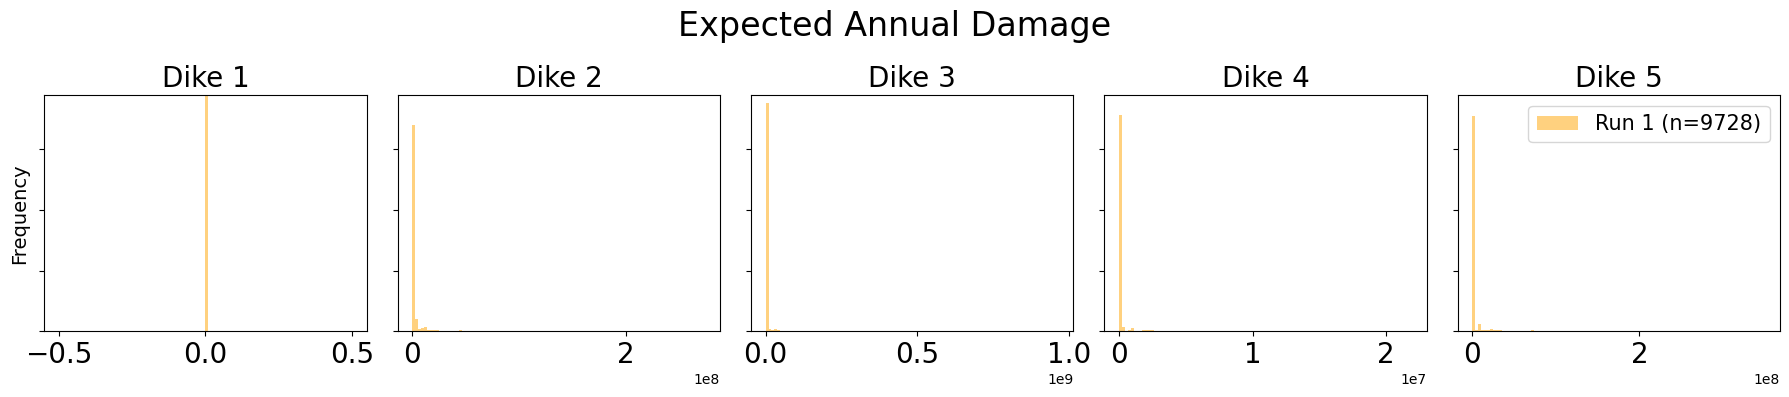

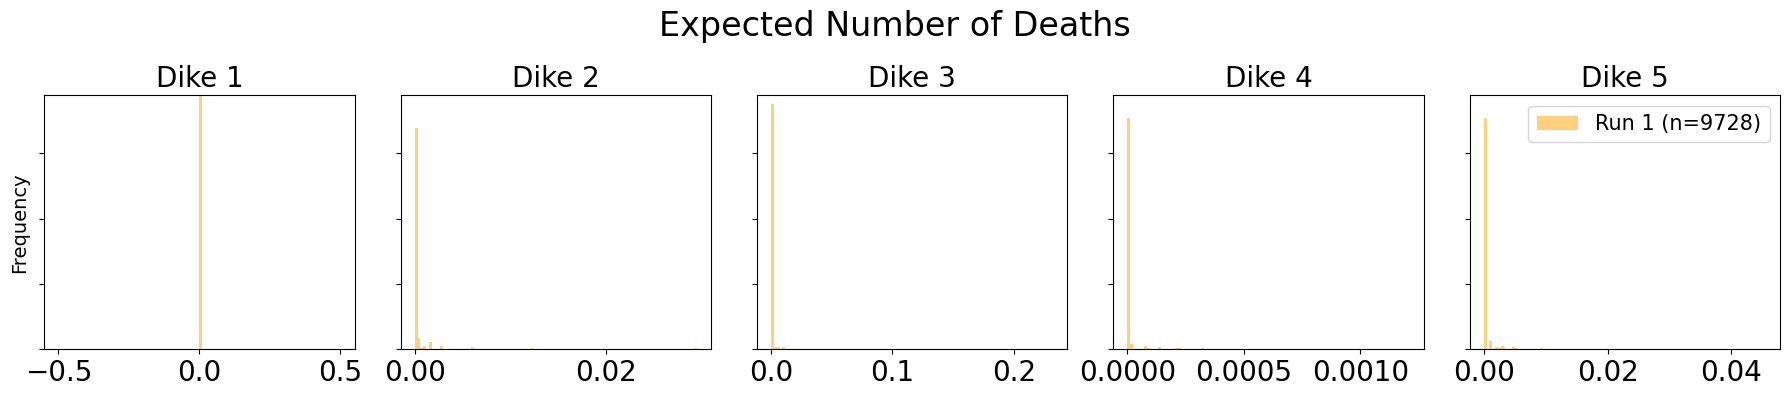

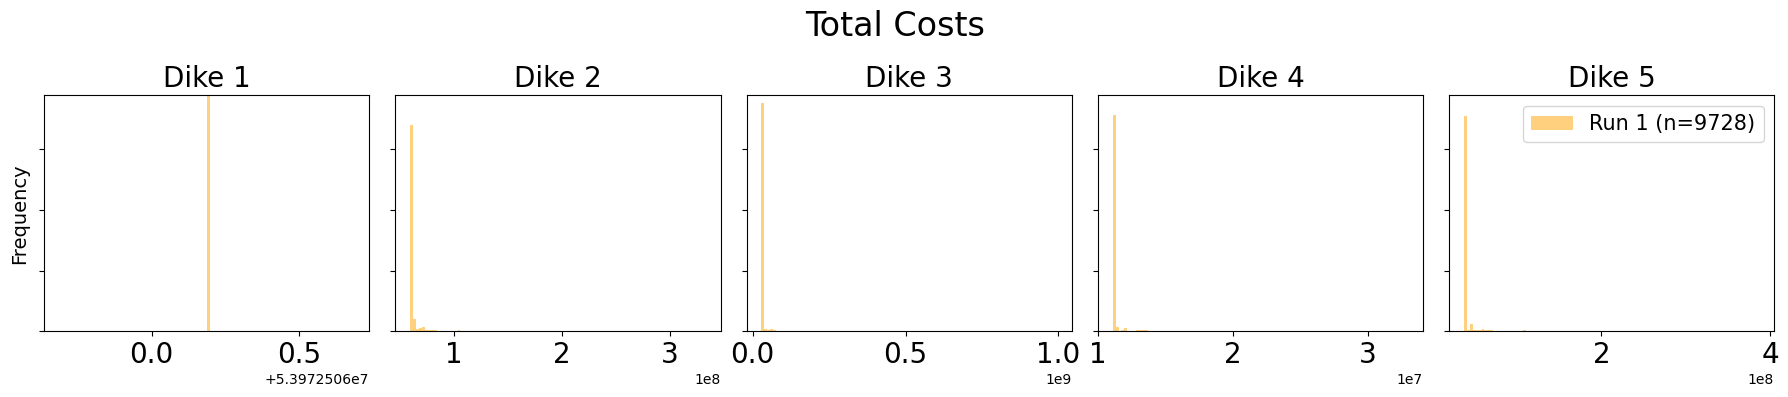

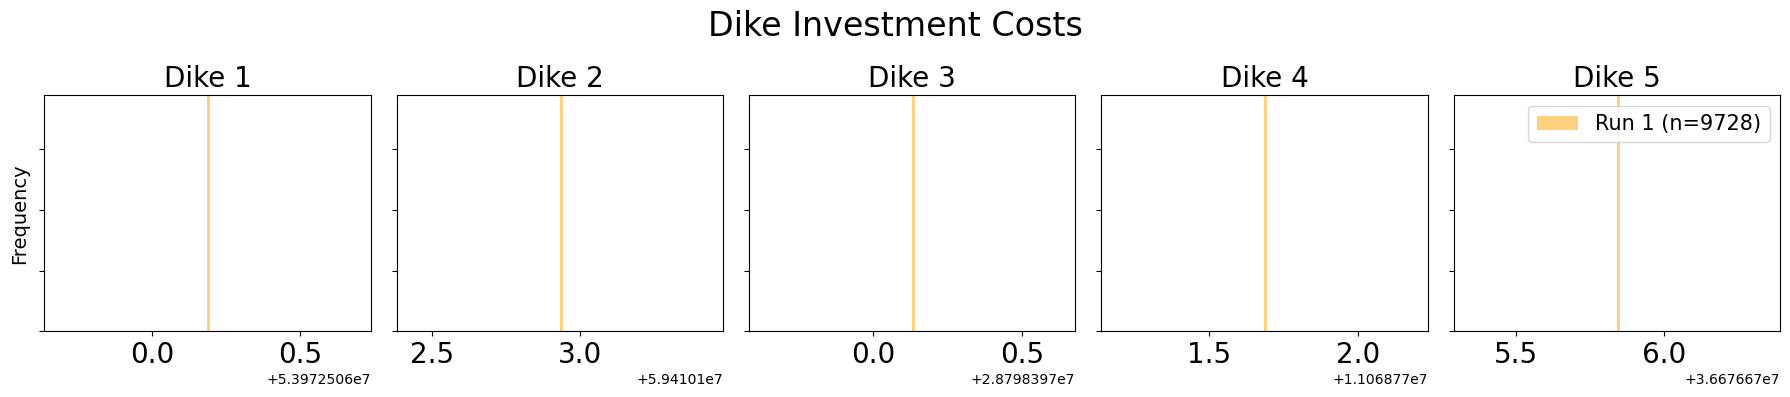

Figure 1: Histograms of disaggregated outcomes for all dikes in normal scale.


In [20]:
## Histogram plot - normal scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs", "Dike Investment Costs"]

# Plot histograms for each disaggregated outcome for all dikes
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
    # Collect all data to determine global y-limits
    all_hist_data = []
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        all_hist_data.append(outcomes[key])
    # Compute global y-limits
    counts = []
    for data in all_hist_data:
        c, _ = np.histogram(data, bins=30)
        counts.append(c)
    global_ylim = (0, max([c.max() for c in counts]))

    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes[key], bins=100, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylim(global_ylim)
        if i == 0:
            axes[i].set_ylabel("Frequency", fontsize=14)
            axes[i].tick_params(axis='both', which='major', labelsize=20)
        else:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel("")
            axes[i].tick_params(axis='x', which='major', labelsize=20)
        if i == 4:
            axes[i].legend(fontsize=15)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout()
    plt.show()

print("Figure 1: Histograms of disaggregated outcomes for all dikes in normal scale.")

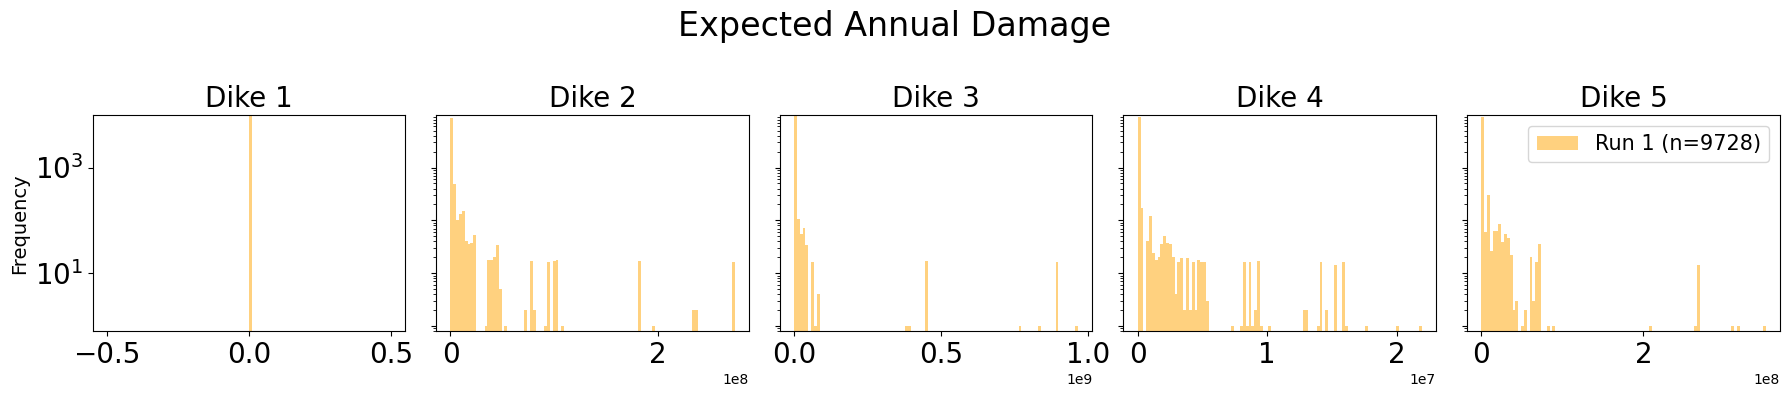

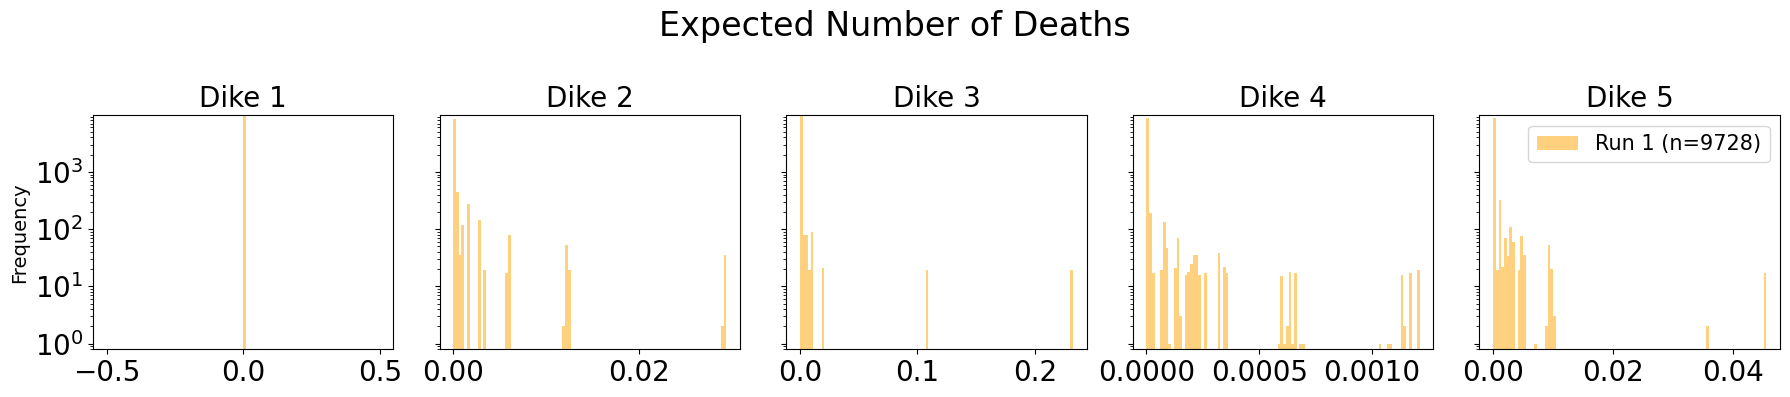

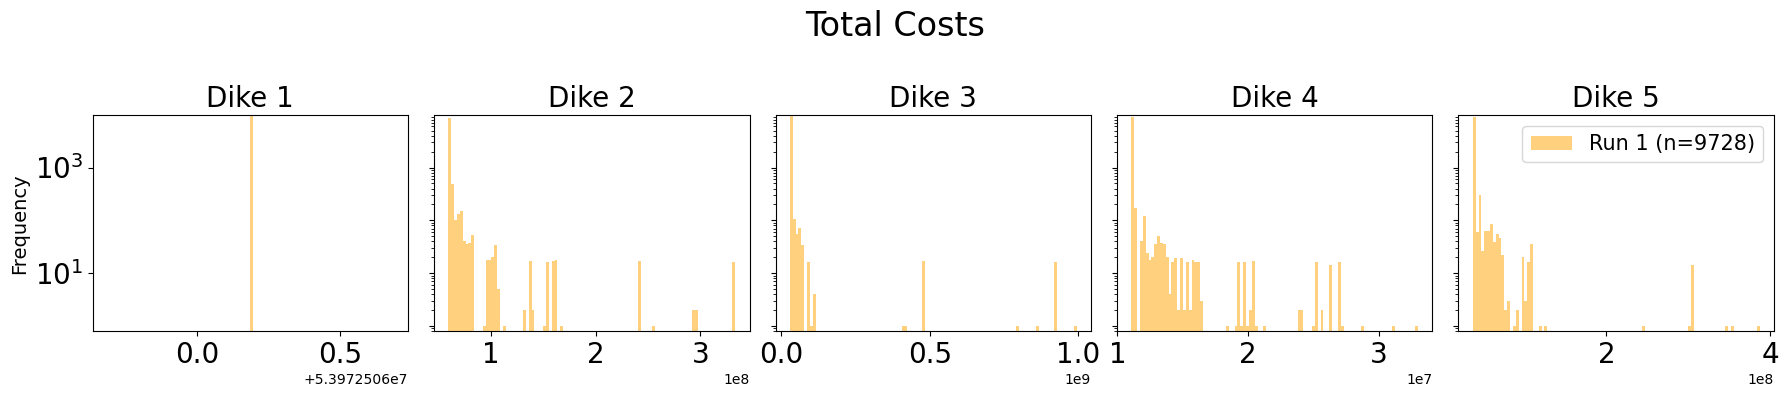

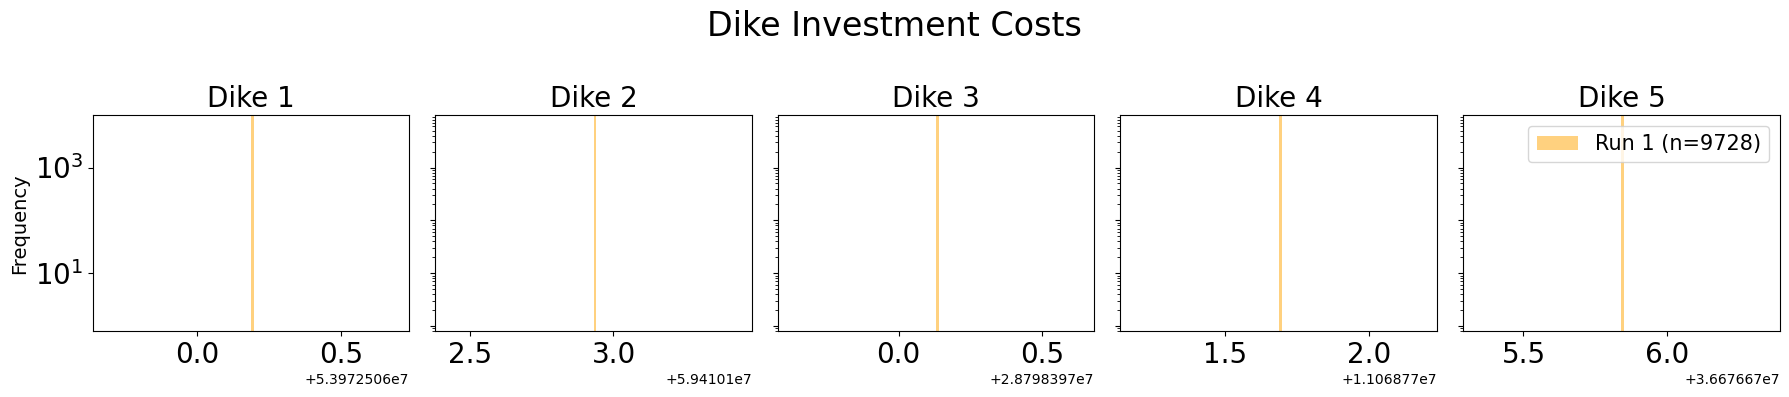

Figure 2: Histograms of disaggregated outcomes for all dikes in log scale.


In [21]:
## Histogram plot - log scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs", "Dike Investment Costs"]

# Plot histograms for each disaggregated outcome for all dikes (single run, log scale)
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    # Collect all data to determine global y-limits
    all_hist_data = []
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        all_hist_data.append(outcomes[key])
    # Compute global y-limits
    counts = []
    for data in all_hist_data:
        c, _ = np.histogram(data, bins=30)
        counts.append(c)
    global_ylim = (0.8, max([c.max() for c in counts]))  # start from 0.8 for log scale

    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes[key], bins=100, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_yscale('log')
        axes[i].set_ylim(global_ylim)
        if i == 0:
            axes[i].set_ylabel("Frequency", fontsize=14)
            axes[i].tick_params(axis='both', which='major', labelsize=20)
        else:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel("")
            axes[i].tick_params(axis='x', which='major', labelsize=20)
        if i == 4:
            axes[i].legend(fontsize=15)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 2: Histograms of disaggregated outcomes for all dikes in log scale.")

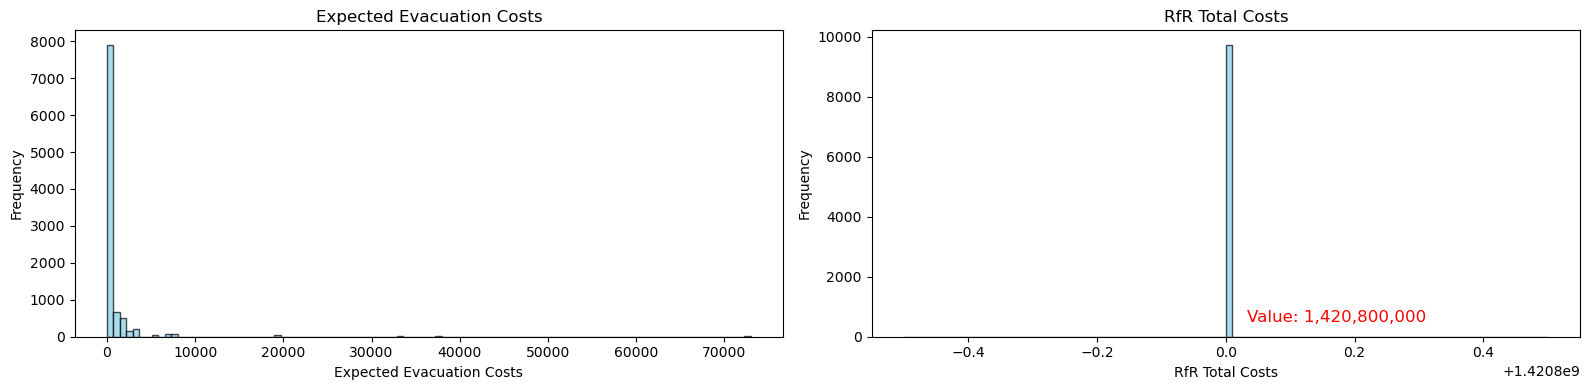

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Histogram for Expected Evacuation Costs
axes[0].hist(outcomes["Expected Evacuation Costs"], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Expected Evacuation Costs")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Expected Evacuation Costs")

# Histogram for RfR Total Costs
axes[1].hist(outcomes["RfR Total Costs"], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel("RfR Total Costs")
axes[1].set_ylabel("Frequency")
axes[1].set_title("RfR Total Costs")

# Display the first value of the cost in the plot
first_cost = outcomes["RfR Total Costs"][0]
axes[1].annotate(f"    Value: {first_cost:,.0f}", xy=(first_cost, 0), xytext=(first_cost, 500), fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Trade offs

In [32]:
from collections import Counter

def classify_scenarios_by_percentile(outcomes, outcome_key, low=0, high=100):
    """
    Classify scenarios based on the percentile of a specific outcome.
    
    Parameters:
        outcomes (dict): Dictionary of outcome arrays.
        outcome_key (str): Key of the outcome to classify on (e.g., "A.5_Expected Number of Deaths").
        low (float): Lower percentile (e.g., 0 for min, 25 for first quartile).
        high (float): Upper percentile (e.g., 100 for max, 75 for third quartile).
    
    Returns:
        np.ndarray: Array of labels ("low", "mid", "high") for each scenario.
    """
    values = outcomes[outcome_key]
    low_thresh = np.percentile(values, low)
    high_thresh = np.percentile(values, high)
    labels = np.full(len(values), "mid", dtype=object)
    labels[values <= low_thresh] = "low"
    labels[values >= high_thresh] = "high"
    return labels

In [33]:
from ema_workbench.analysis import parcoords

def plot_scenarios_by_percentile(outcomes, outcome_label, low=0, high=95):
    """
    Plot parallel coordinates of scenarios colored by percentile-based labels for a given outcome.

    Parameters:
        outcomes (dict): Dictionary of outcome arrays.
        outcome_label (str): Key of the outcome to classify on (e.g., "A.5_Expected Number of Deaths").
        low (float): Lower percentile (default 0).
        high (float): Upper percentile (default 95).
    """
    labels = classify_scenarios_by_percentile(outcomes, outcome_label, low=low, high=high)
    label_counts = Counter(labels)
    print(label_counts)
    print(f"Total scenarios: {len(labels)}")

    # Prepare all outcomes as a DataFrame (only outcome columns)
    all_outcome_cols = [col for col in outcomes.keys() if col.startswith("A.") and (
        "Expected Annual Damage" in col or "Expected Number of Deaths" in col or "Total Costs" in col)]
    all_data = pd.DataFrame({k: outcomes[k] for k in all_outcome_cols})

    # Add percentile-based labels to the data
    all_data['Label'] = labels

    # Get limits for the parallel coordinates plot
    limits = parcoords.get_limits(all_data[all_outcome_cols])

    # Define colors for each label
    label_colors = {
        "mid": "#cccccc",  # for unlabeled/mid cases
        "low": "#2ca02c",
        "high": "#ec4444"
    }

    plt.figure(figsize=(5, 5))
    paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=8)

    # Plot each group by label
    unique_labels = [l for l in ["low", "mid", "high"] if l in np.unique(labels)]
    for label in unique_labels:
        group = all_data[all_data['Label'] == label]
        color = label_colors.get(label, "#cccccc")
        paraxes.plot(group[all_outcome_cols], color=color, lw=1, alpha=0.05, label=f"{label} ({len(group)})")

    paraxes.legend()
    plt.title(f"Outcome Tradeoff Plot: Scenarios by Percentile of {outcome_label}", loc='right')
    plt.tight_layout()
    plt.show()

Counter({'low': 8764, 'high': 499, 'mid': 465})
Total scenarios: 9728


C:\Users\Move\AppData\Local\Temp\ipykernel_9380\177377023.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 500x500 with 0 Axes>

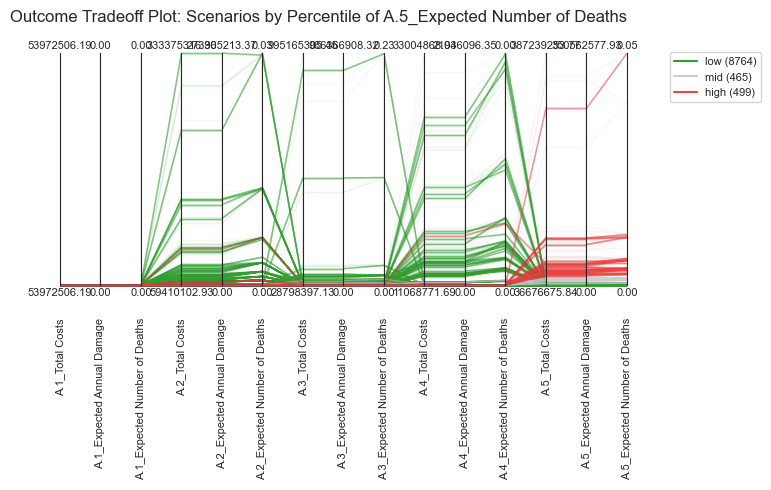

In [38]:
# Example usage:
plot_scenarios_by_percentile(outcomes, "A.5_Expected Number of Deaths", low=90, high=95)

Counter({'low': 8867, 'high': 488, 'mid': 373})
Total scenarios: 9728


C:\Users\Move\AppData\Local\Temp\ipykernel_9380\177377023.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 500x500 with 0 Axes>

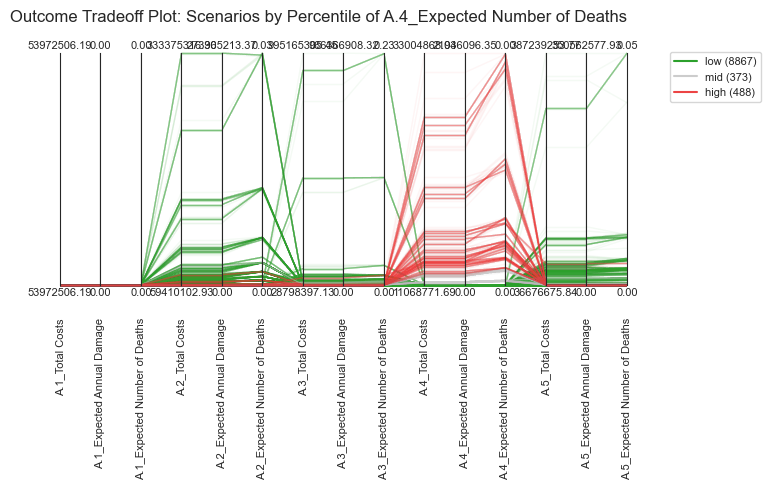

In [39]:
plot_scenarios_by_percentile(outcomes, "A.4_Expected Number of Deaths", low=90, high=95)